In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from keras_tuner import RandomSearch
import os
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

In [2]:
def crop_brain_contour(image, plot=False):
    # convert to gray
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    
    cnts = cv2.findContours(
        thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    
    
    if plot:
        plt.imshow(new_image)
    return new_image

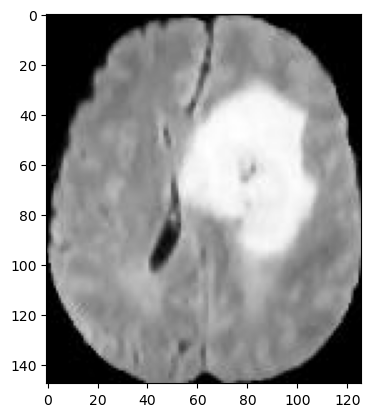

In [3]:
ex_img = cv2.imread('augmented data/yes/Image10.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [4]:
def load_data(dir_list, image_size):
    X = []
    y = []
    image_width, image_height = image_size
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(os.path.join(directory, filename))
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(
                image_width, image_height), interpolation=cv2.INTER_CUBIC)
            image = image / 255.0
            X.append(image)
            y.append([1] if directory[-3:] == 'yes' else [0])
    X = np.array(X)
    y = np.array(y)
    X, y = shuffle(X, y)
    return X, y

In [5]:
augmented_path = 'augmented data/'
augmented_yes = os.path.join(augmented_path, 'yes')
augmented_no = os.path.join(augmented_path, 'no')
IMG_WIDTH, IMG_HEIGHT = 240, 240
X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

In [6]:
X.shape

(3762, 240, 240, 3)

In [7]:
y.shape

(3762, 1)

In [8]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    for label in [0, 1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n / columns_n)

        plt.figure(figsize=(20, 10))

        i = 1  # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        def label_to_str(label): return "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

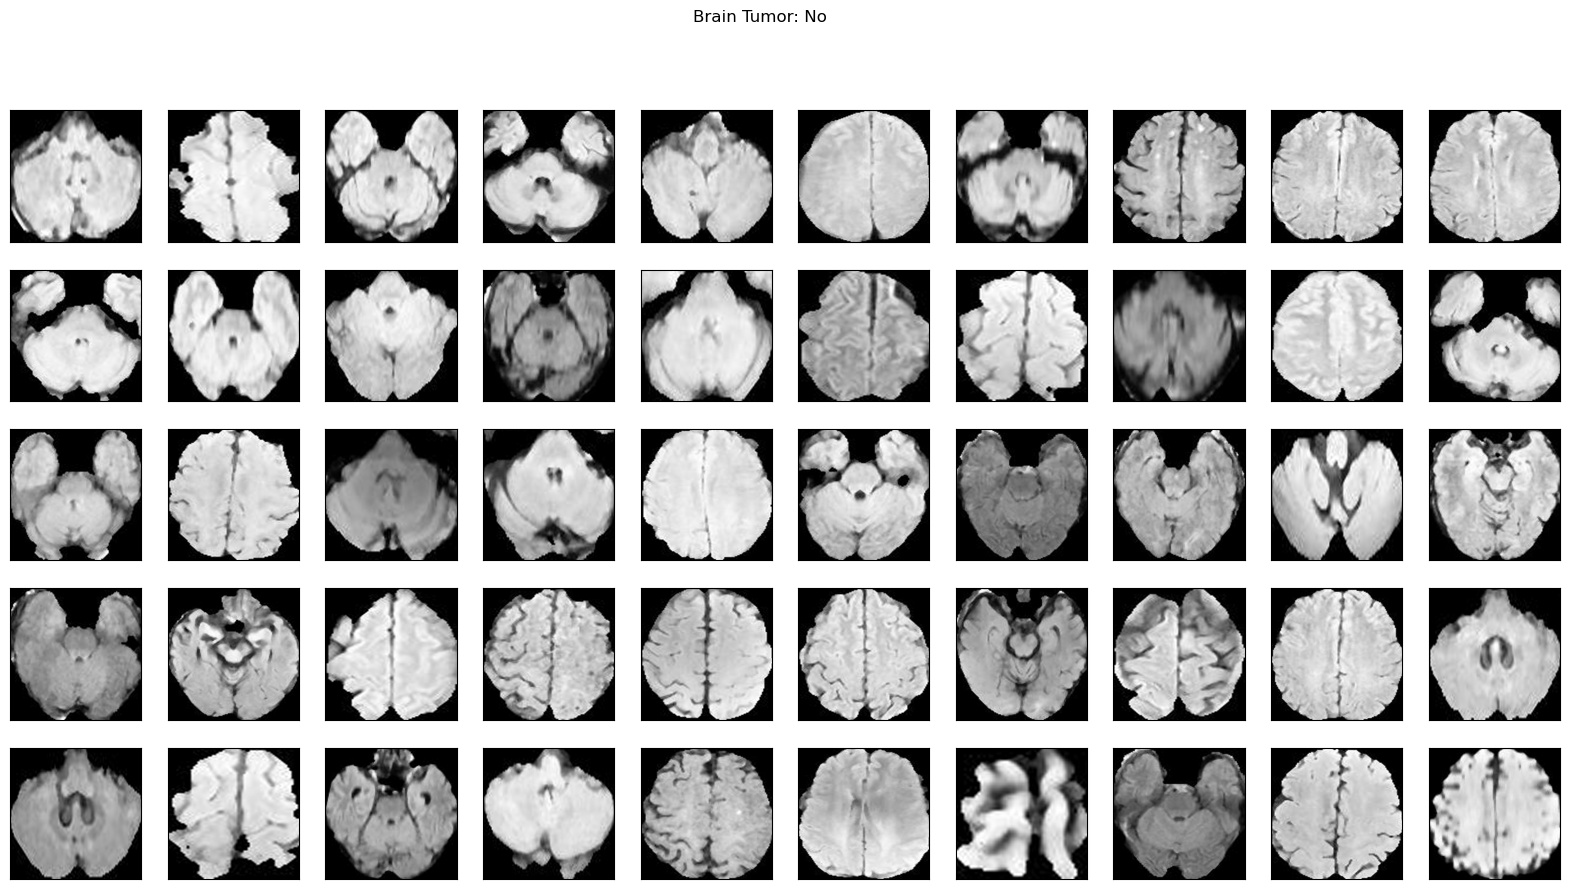

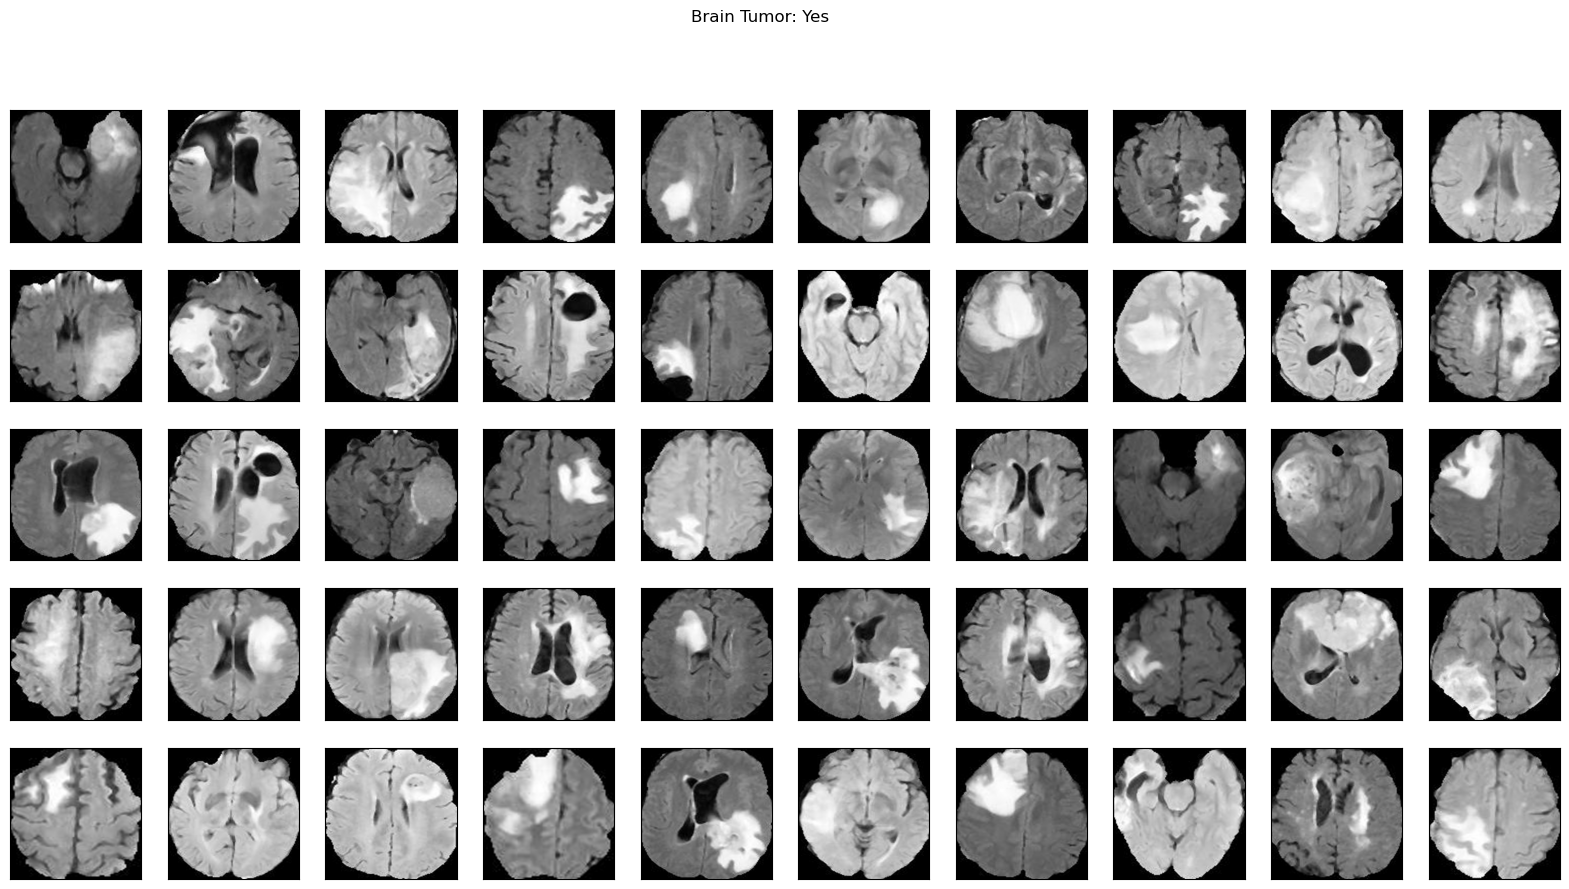

In [27]:
plot_sample_images(X, y)

In [9]:
def split_data(X, y, test_size=0.3):
    X_train, X_test_val, y_train, y_test_val = train_test_split(
        X, y, test_size=test_size, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(
        X_test_val, y_test_val, test_size=0.5, random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [10]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(
    X, y, test_size=0.3)

In [11]:
print("number of training examples = " + str(X_train.shape[0]))
print("number of development examples = " + str(X_val.shape[0]))
print("number of test examples = " + str(X_test.shape[0]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(y_train.shape))
print("X_val (dev) shape: " + str(X_val.shape))
print("Y_val (dev) shape: " + str(y_val.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(y_test.shape))


number of training examples = 2633
number of development examples = 565
number of test examples = 564
X_train shape: (2633, 240, 240, 3)
Y_train shape: (2633, 1)
X_val (dev) shape: (565, 240, 240, 3)
Y_val (dev) shape: (565, 1)
X_test shape: (564, 240, 240, 3)
Y_test shape: (564, 1)


In [12]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [13]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)

    score = f1_score(y_true, y_pred)

    return score

In [14]:
# Build the model with hyperparameter tuning
def build_model(hp):
    X_input = Input((240, 240, 3))
    X = ZeroPadding2D((2, 2))(X_input)
    X = Conv2D(hp.Int('conv_filters', min_value=32, max_value=128,
               step=16), (7, 7), strides=(1, 1), name='conv0')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((4, 4), name='max_pool0')(X)
    X = MaxPooling2D((4, 4), name='max_pool1')(X)
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)
    model = Model(inputs=X_input, outputs=X, name='BrainDetectionModel')
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [34]:
tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=10,
                     executions_per_trial=1, directory='model_tuning', project_name='brain_tumor_detection')
tuner.search(x=X_train, y=y_train, epochs=10, validation_data=(X_val, y_val))

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# After hyperparameter tuning, use the best model for further training and evaluation
best_model.summary()

Trial 10 Complete [00h 20m 23s]
val_accuracy: 0.913274347782135

Best val_accuracy So Far: 0.9274336099624634
Total elapsed time: 05h 45m 51s


/Users/fightfei/anaconda3/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 80)   │        11,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 80)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 238, 238, 80)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 59, 59, 80)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 14, 14, 80)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15680)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │        15,681 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,841 (108.75 KB)

 Trainable params: 27,681 (108.13 KB)

 Non-trainable params: 160 (640.00 B)

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

completed_trials = tuner.oracle.get_best_trials(num_trials=10)

trial_ids = []
val_accuracies = []
hyperparameters = []

for trial in completed_trials:
    trial_ids.append(trial.trial_id)
    val_accuracies.append(trial.score) 
    hyperparameters.append(trial.hyperparameters.values)

df = pd.DataFrame({
    'Trial ID': trial_ids,
    'Validation Accuracy': val_accuracies,
    'Hyperparameters': hyperparameters
})

df.sort_values('Validation Accuracy', ascending=False, inplace=True)

plt.figure(figsize=(10, 8))
plt.barh(df['Trial ID'], df['Validation Accuracy'], color='skyblue')
plt.xlabel('Validation Accuracy')
plt.ylabel('Trial ID')
plt.title('Validation Accuracy of Each Trial')
plt.xlim([0.5, 1.0]) 
plt.show()


NameError: name 'tuner' is not defined

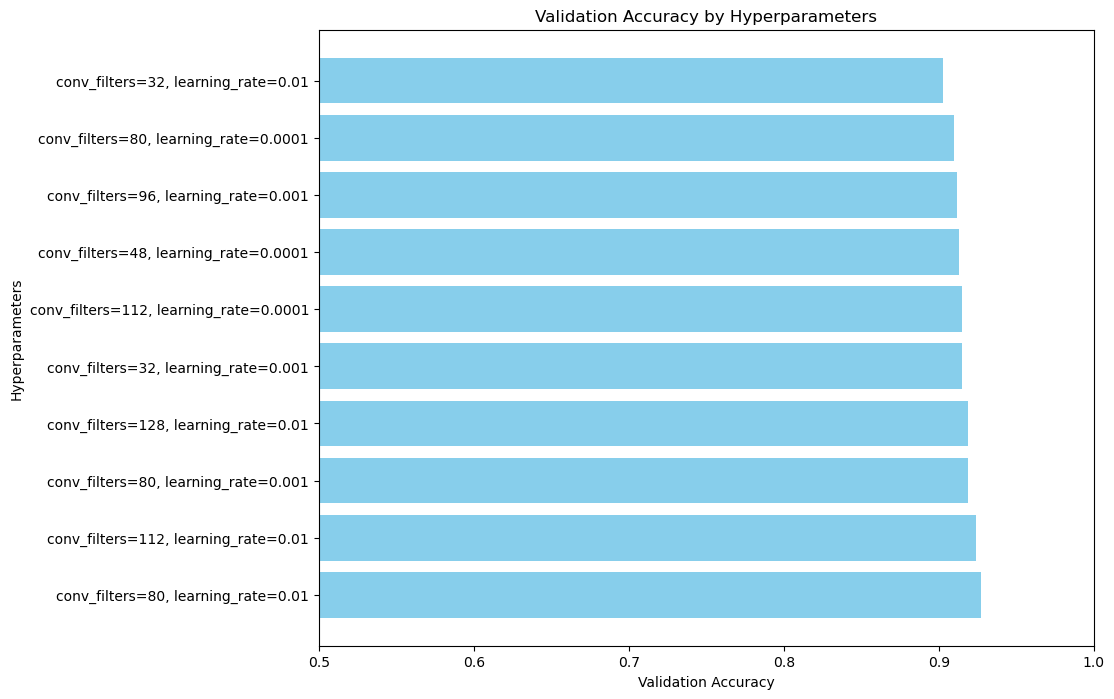

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

completed_trials = tuner.oracle.get_best_trials(num_trials=10)

val_accuracies = []
hyperparameters_labels = []
# Extract data from each trial
for trial in completed_trials:
    hp_label = ', '.join([f"{key}={value}" for key, value in trial.hyperparameters.values.items()])
    hyperparameters_labels.append(hp_label)
    val_accuracies.append(trial.score) 

df = pd.DataFrame({
    'Hyperparameters': hyperparameters_labels,
    'Validation Accuracy': val_accuracies
})

df.sort_values('Validation Accuracy', ascending=False, inplace=True)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(df['Hyperparameters'], df['Validation Accuracy'], color='skyblue')
plt.xlabel('Validation Accuracy')
plt.ylabel('Hyperparameters')
plt.title('Validation Accuracy by Hyperparameters')
plt.xlim([0.5, 1.0])  
plt.show()


In [17]:
def build_model_manual():
    input_shape = (240, 240, 3)
    X_input = Input(input_shape)
    X = ZeroPadding2D((2, 2))(X_input)
    
    # Set the number of filters, kernel size, and strides manually
    X = Conv2D(64, (7, 7), strides=(1, 1), name='conv0')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((4, 4), name='max_pool0')(X)
    X = MaxPooling2D((4, 4), name='max_pool1')(X)
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)
    model = Model(inputs=X_input, outputs=X, name='BrainDetectionModel')
    
    # Set the optimizer and learning rate manually
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [18]:
model = build_model_manual()

model.summary()

Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_2                │ (None, 244, 244, 3)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 238, 238, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 59, 59, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,273 (87.00 KB)

 Trainable params: 22,145 (86.50 KB)

 Non-trainable params: 128 (512.00 B)

In [19]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.7110 - loss: 0.9082 - val_accuracy: 0.5115 - val_loss: 1.1139
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.8606 - loss: 0.3465 - val_accuracy: 0.6531 - val_loss: 0.9714
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 7785s 95s/step - accuracy: 0.8277 - loss: 0.4839 - val_accuracy: 0.7929 - val_loss: 0.5409
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.9049 - loss: 0.2605 - val_accuracy: 0.8088 - val_loss: 0.4776
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.9124 - loss: 0.2044 - val_accuracy: 0.8779 - val_loss: 0.2891
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.9050 - loss: 0.2357 - val_accuracy: 0.8602 - val_loss: 0.3600
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.9280 - loss: 0.1976 - val_accuracy: 0.8602 - val_loss: 0.3675
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.9239 - loss: 0.2068 - val_accuracy: 0.8885 -

In [20]:
history = model.history.history
history

{'accuracy': [0.7975693345069885,
  0.8613748550415039,
  0.8560577034950256,
  0.8921382427215576,
  0.9077098369598389,
  0.9141663312911987,
  0.927459180355072,
  0.9278389811515808,
  0.9263197779655457,
  0.901253342628479],
 'loss': [0.5754279494285583,
  0.35151293873786926,
  0.3894912302494049,
  0.28061893582344055,
  0.2252511829137802,
  0.22557012736797333,
  0.20298781991004944,
  0.19691893458366394,
  0.18428084254264832,
  0.27271080017089844],
 'val_accuracy': [0.5115044116973877,
  0.6530973315238953,
  0.7929203510284424,
  0.808849573135376,
  0.8778761029243469,
  0.8601769804954529,
  0.8601769804954529,
  0.8884955644607544,
  0.8761062026023865,
  0.7539823055267334],
 'val_loss': [1.1139181852340698,
  0.9714193344116211,
  0.540876030921936,
  0.4775661826133728,
  0.2891351580619812,
  0.3599681854248047,
  0.36746758222579956,
  0.2917875349521637,
  0.32604995369911194,
  1.023179054260254]}

In [23]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

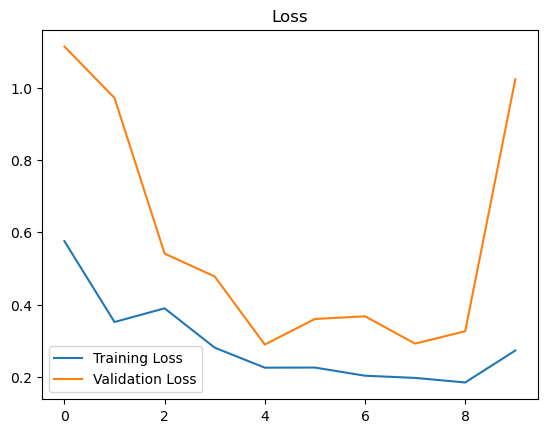

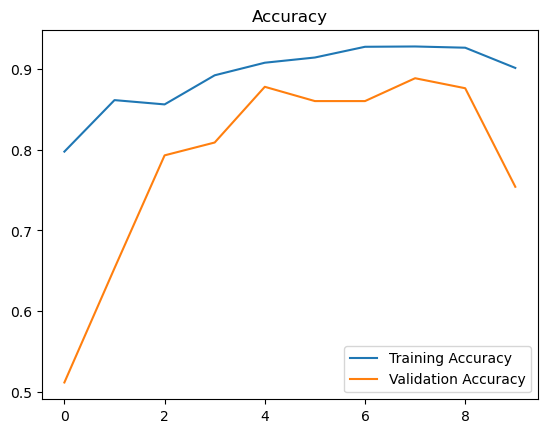

In [24]:
plot_metrics(history) 

In [28]:
model1 = build_model_manual()

In [30]:
start_time = time.time()

model1.fit(x=X_train, y=y_train, batch_size=64, epochs=10, validation_data=(X_val, y_val))

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 176s 4s/step - accuracy: 0.9023 - loss: 0.2571 - val_accuracy: 0.8212 - val_loss: 0.3752
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1529s 37s/step - accuracy: 0.8826 - loss: 0.2940 - val_accuracy: 0.8000 - val_loss: 0.4209
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 166s 4s/step - accuracy: 0.9074 - loss: 0.2365 - val_accuracy: 0.8566 - val_loss: 0.3316
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 162s 4s/step - accuracy: 0.9247 - loss: 0.1930 - val_accuracy: 0.8159 - val_loss: 0.4242
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 154s 4s/step - accuracy: 0.9208 - loss: 0.2015 - val_accuracy: 0.7204 - val_loss: 0.7563
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 151s 4s/step - accuracy: 0.9077 - loss: 0.2161 - val_accuracy: 0.7823 - val_loss: 0.5253
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 158s 4s/step - accuracy: 0.9190 - loss: 0.2021 - val_accuracy: 0.8655 - val_loss: 0.3258
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 177s 4s/step - accuracy: 0.9283 - loss: 0.1931 - val_accuracy: 0.8867 -

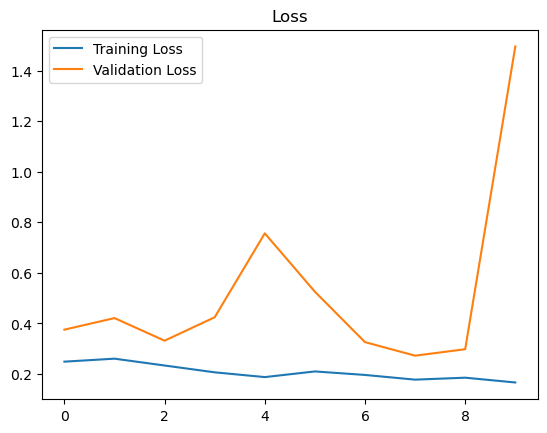

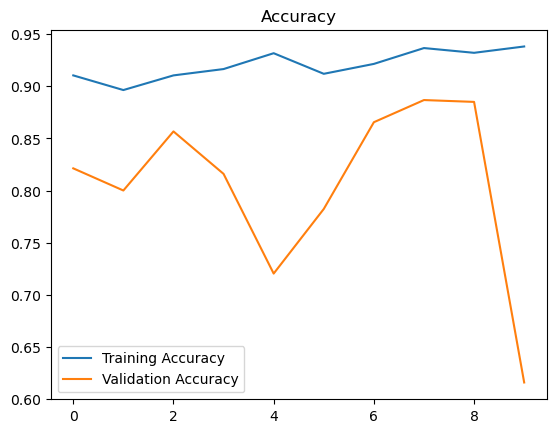

In [31]:
history1 = model1.history.history
plot_metrics(history1) 

In [39]:
history1

{'accuracy': [0.9103683829307556,
  0.8963159918785095,
  0.9103683829307556,
  0.9164451360702515,
  0.9316369295120239,
  0.9118875861167908,
  0.9213824272155762,
  0.9365742206573486,
  0.9320167303085327,
  0.9380934238433838],
 'loss': [0.24857690930366516,
  0.26035380363464355,
  0.23332418501377106,
  0.20632098615169525,
  0.1874721348285675,
  0.20985564589500427,
  0.19596770405769348,
  0.1773652732372284,
  0.18510404229164124,
  0.16616253554821014],
 'val_accuracy': [0.8212389349937439,
  0.800000011920929,
  0.856637179851532,
  0.8159291744232178,
  0.7203539609909058,
  0.7823008894920349,
  0.865486741065979,
  0.886725664138794,
  0.8849557638168335,
  0.6159291863441467],
 'val_loss': [0.37523603439331055,
  0.42094162106513977,
  0.3315873146057129,
  0.4242463707923889,
  0.7562633156776428,
  0.5253261923789978,
  0.3258439600467682,
  0.27222248911857605,
  0.29787564277648926,
  1.4957572221755981]}

In [32]:
model2 = build_model_manual()
start_time = time.time()

model2.fit(x=X_train, y=y_train, batch_size=16, epochs=10, validation_data=(X_val, y_val))

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 160s 961ms/step - accuracy: 0.7630 - loss: 0.7219 - val_accuracy: 0.6177 - val_loss: 1.3076
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 143s 869ms/step - accuracy: 0.8733 - loss: 0.3413 - val_accuracy: 0.8513 - val_loss: 0.3439
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 141s 855ms/step - accuracy: 0.9017 - loss: 0.2719 - val_accuracy: 0.8673 - val_loss: 0.3294
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 833s 5s/step - accuracy: 0.8796 - loss: 0.3124 - val_accuracy: 0.8832 - val_loss: 0.3039
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 143s 864ms/step - accuracy: 0.8943 - loss: 0.2808 - val_accuracy: 0.8513 - val_loss: 0.4661
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 147s 887ms/step - accuracy: 0.8995 - loss: 0.2733 - val_accuracy: 0.8726 - val_loss: 0.3432
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 1150s 7s/step - accuracy: 0.8875 - loss: 0.2904 - val_accuracy: 0.8637 - val_loss: 0.3897
Epoch 8/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 1392s 8s/step - accuracy: 0.9021 - loss: 

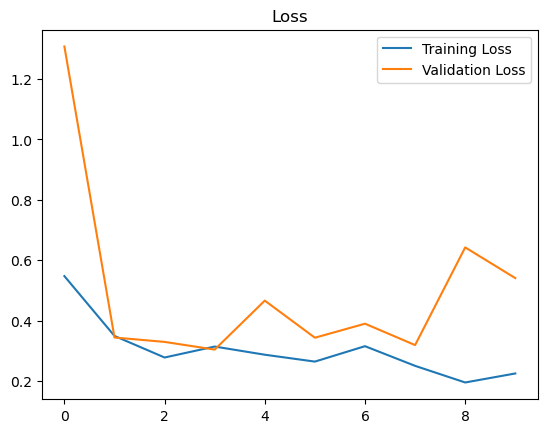

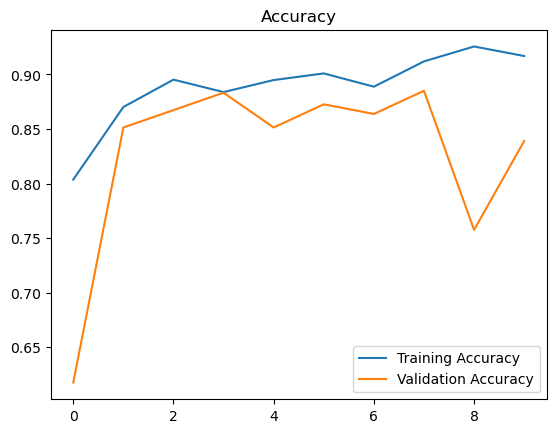

In [34]:
history2 = model2.history.history
plot_metrics(history2) 

In [37]:
model3 = build_model_manual()
start_time = time.time()

model3.fit(x=X_train, y=y_train, batch_size=8, epochs=10, validation_data=(X_val, y_val))

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 123s 370ms/step - accuracy: 0.7816 - loss: 0.6436 - val_accuracy: 0.6195 - val_loss: 2.9091
Epoch 2/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 115s 350ms/step - accuracy: 0.8638 - loss: 0.4898 - val_accuracy: 0.7982 - val_loss: 0.7253
Epoch 3/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 114s 347ms/step - accuracy: 0.8635 - loss: 0.4339 - val_accuracy: 0.8761 - val_loss: 0.3233
Epoch 4/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 110s 334ms/step - accuracy: 0.8710 - loss: 0.3598 - val_accuracy: 0.8496 - val_loss: 0.4939
Epoch 5/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 109s 331ms/step - accuracy: 0.8864 - loss: 0.3122 - val_accuracy: 0.8779 - val_loss: 0.3722
Epoch 6/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 112s 339ms/step - accuracy: 0.9103 - loss: 0.2240 - val_accuracy: 0.8124 - val_loss: 0.6411
Epoch 7/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 113s 343ms/step - accuracy: 0.9096 - loss: 0.2294 - val_accuracy: 0.8726 - val_loss: 0.3679
Epoch 8/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 116s 352ms/step - accuracy: 0.8987 -

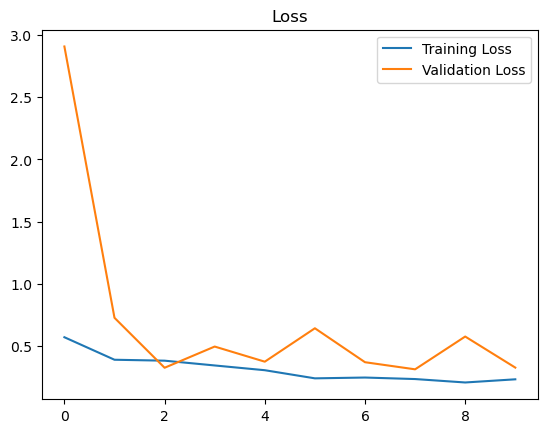

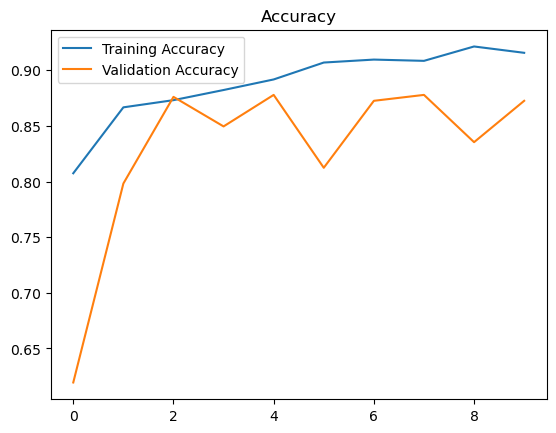

In [38]:
history3 = model3.history.history
plot_metrics(history3) 